
> Authors: Guillaume Martin and Andrei Barbu

For this challenge, we have to predict the types of trees ("Cover_Type") present in a region by using geological data corresponding to the region.

A few initial remarks: We notice that the data provided (i.e., the labeled data) only represents a small portion of the total dataset—around $15,000$ points are given to predict on a dataset of approximately $500,000$ points. Furthermore, the leaderboard represents the predictions of the model being tested on a small part of the final dataset. When combined with the fact that we have only a small training set, we realize we may be prone to overfitting. Hence, this is what we will aim to avoid. Finally, we do not include all unsuccessful explorations but focus on the methods that yielded the most results or were intrinsically significant. As we faced a clear difference between the leaderbard score on kaggle and the accuracy we used with cross validation, we decided to focus only on the cross validation accuracy, a better performance indicator and enabling us to not "overfit" hyperparameters to the test set.

In [84]:
# all the usefull imports
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import mutual_info_classif
from sklearn.model_selection import train_test_split, StratifiedKFold
from category_encoders import TargetEncoder
import matplotlib.pyplot as plt

# Preprocessing

In [85]:
df=pd.read_csv("../data/train.csv")
df=df.set_index("Id")
#Reshuffles the data set
df=df.sample(frac=1)
df["Cover_Type"]=df["Cover_Type"]-1

We reshuffle the dataset so that there is no information in the index.

There shouldn't be, but during our exploration, we noticed an improvement in the results when submitted to the challenge by using the indices as a feature. Since we consider indices (0, 1, 2, 3...) to be only a representation feat and not information linked to any geological meaning, we won't use it, even though it yields better results on the leaderboard.

In [101]:
#Balanced dataset regarding Cover_Type
df["Cover_Type"].value_counts()

6    2160
2    2160
0    2160
4    2160
3    2160
5    2160
1    2160
Name: Cover_Type, dtype: int64

In [102]:
#We can see that the target here is fully balanced.
df.groupby("Cover_Type").count()

Elevation  Aspect  Slope  Horizontal_Distance_To_Hydrology  \
Cover_Type                                                               
0                2160    2160   2160                              2160   
1                2160    2160   2160                              2160   
2                2160    2160   2160                              2160   
3                2160    2160   2160                              2160   
4                2160    2160   2160                              2160   
5                2160    2160   2160                              2160   
6                2160    2160   2160                              2160   

            Vertical_Distance_To_Hydrology  Horizontal_Distance_To_Roadways  \
Cover_Type                                                                    
0                                     2160                             2160   
1                                     2160                             2160   
2                                     2160                             2160   
3                                     2160                             2160   
4                                     2160                             2160   
5                                     2160                             2160   
6                                     2160                             2160   

            Hillshade_9am  Hillshade_Noon  Hillshade_3pm  \
Cover_Type                                                 
0                    2160            2160           2160   
1                    2160            2160           2160   
2                    2160            2160           2160   
3                    2160            2160           2160   
4                    2160            2160           2160   
5                    2160            2160           2160   
6                    2160            2160           2160   

            Horizontal_Distance_To_Fire_Points  ...  Soil_Type31  Soil_Type32  \
Cover_Type                                      ...                             
0                                         2160  ...         2160         2160   
1                                         2160  ...         2160         2160   
2                                         2160  ...         2160         2160   
3                                         2160  ...         2160         2160   
4                                         2160  ...         2160         2160   
5                                         2160  ...         2160         2160   
6                                         2160  ...         2160         2160   

            Soil_Type33  Soil_Type34  Soil_Type35  Soil_Type36  Soil_Type37  \
Cover_Type                                                                    
0                  2160         2160         2160         2160         2160   
1                  2160         2160         2160         2160         2160   
2                  2160         2160         2160         2160         2160   
3                  2160         2160         2160         2160         2160   
4                  2160         2160         2160         2160         2160   
5                  2160         2160         2160         2160         2160   
6                  2160         2160         2160         2160         2160   

            Soil_Type38  Soil_Type39  Soil_Type40  
Cover_Type                                         
0                  2160         2160         2160  
1                  2160         2160         2160  
2                  2160         2160         2160  
3                  2160         2160         2160  
4                  2160         2160         2160  
5                  2160         2160         2160  
6                  2160         2160         2160  

[7 rows x 54 columns]

It is important that the dataset contains the same amount of every objective class so that the predictor is not biased towards one specific class. Having an unbalanced training set may lead to poor performances. For example with two classes, having one at $90\%$ and one at $10\%$, to have a $90\%$ accuracy, you can just predict the first class. Clearly, in this case the predictor is bad even though it yields "good" results.

In [103]:
encoders=[tuple([TargetEncoder() for _ in range(4)]) for i in range(7)]

We create a function in which we include all the preprocessing steps for the dataset. This involves setting cover_type as the objective, splitting the elu codes to obtain climatic and geologic zone codes, and target encoding the various categorical variables. The target encoding, designed for a multiclass problem, involves targeting each variable with 7 columns (for the 7 classes), providing the proportion of 'Cover_Type' for that class.

We anticipate that Target encoding will improve results, primarily because it reduces the number of columns, notably for soil_type. Additionally, it allows for a Bayesian approach and effectively represents the information between 'Cover_Type' and the feature. However, it is susceptible to overfitting, necessitating caution to prevent target leakage. Hence, we will fit using only the training data and then transform the train and validation data using the fitted TargetEncoder.

In [89]:
def preprocess(X,Y,fit: bool) :
    X["Cover_Type"] = Y
    elu_codes = [
    "2702", "2703", "2704", "2705", "2706", "2717", "3501", "3502", 
    "4201", "4703", "4704", "4744", "4758", "5101", "5151", "6101", 
    "6102", "6731", "7101", "7102", "7103", "7201", "7202", "7700", 
    "7701", "7702", "7709", "7710", "7745", "7746", "7755", "7756", 
    "7757", "7790", "8703", "8707", "8708", "8771", "8772", "8776"
    ]

    soil_types=[f"Soil_Type{i+1}" for i in range(40)]

    only_soil=X[soil_types]
    
    #Creates a dataframe with only one column containing the ELU Code
    elu_df=pd.DataFrame(only_soil.apply(lambda row:elu_codes[int(row.idxmax()[9:])-1],axis=1),index=X.index)
    elu_df=elu_df.rename(columns={0:"ELU"})
    
    #Creates Climatic and Geologic columns in X with this ELU Code
    X["Climatic"]=elu_df["ELU"].str[0]
    X["Geologic"]=elu_df["ELU"].str[1]
    
    #Target Encoding for Wilderness_Area Soil_Type Climatic Geologic for each of the 7 Cover_Type classes
    columns_to_drop=[("Wilderness_Area",4),("Soil_Type",40),("Climatic",0),("Geologic",0)]
    for idx in range(4):
        col,n=columns_to_drop[idx]
        if n>0:
            col_list=[f"{col}{i}" for i in range(1,n+1)] 
            X[col]=X[col_list].apply(lambda row:row.idxmax(),axis=1)
            X=X.drop(columns=col_list)
        for i in range(7) :
            if fit :
                X[f"{col}{i}"]=encoders[i][idx].fit_transform(X[col],X["Cover_Type"]==i)
            else:
                X[f"{col}{i}"]=encoders[i][idx].transform(X[col])
        X=X.drop(columns=col)
    X=X.drop(columns=["Cover_Type"])
    
    return X

# Training

After exploring different models for this classification model, decision trees seemed the most relevant to the problem. And after trying them out, indeed an Gradient Boosted Random forest yields the best results. So we decided to use an XGBClassifier model. Given the nature of this model we do not need to perform some rescaling.

In [90]:
# This will be the full dataset split between features and objectives throughout the project.
X=df.drop(columns=["Cover_Type"])
Y=df["Cover_Type"]

In [104]:
#Plots the multi class error for the train set and validation set during the training of the XGBoost model. 
def plot_results(model) :
    res=model.evals_result()
    epochs=len(res["validation_0"]["merror"])
    plt.plot(range(epochs),res["validation_0"]["merror"],label="Train")
    plt.plot(range(epochs),res["validation_1"]["merror"],label="Validation")
    plt.xlabel("")
    plt.ylabel("Percentage of error")
    plt.title("Percentage of error on the validation and test sets with increasing data used")
    plt.legend()
    plt.show()    

To train the model, we had some choices to make. Firstly, for testing, we used StratifiedKFold Cross-Validation. This allows us to maintain the same proportions of every target class in both the training set and the test set.

The parameters of the XGBClassifier were selected with two objectives in mind: avoiding overfitting and optimizing performance.

The choices are made using a softmax method.

We limit the maximum depth of the trees in the random forests to control overfitting. We also maintain a low number of estimators for the same purpose. Following a similar strategy, and perhaps more efficiently, we restrict the subsamples of the training of every estimator to a proportion of only $0.7$ of the training dataset, ensuring that any emerging information is more evenly spread and global. We halt the boosting algorithm after 100 rounds.

The optimization has been performed iteratively by manually testing different values and converging towards an optimal configuration.

In [92]:
n_estim=600
learn_r=0.02
obj = 'multi:softmax'
max_dp=12
subs=0.7
evalm=["merror"]
early_stop_rd=100

train_acc=0
acc=0

#StratifiedKFold Cross Validation with 5 different folds
for train_idx,val_idx in StratifiedKFold(n_splits=5).split(X,Y) :
    X_train=X.iloc[train_idx].copy()
    Y_train=Y.iloc[train_idx].copy()
    X_val=X.iloc[val_idx].copy()
    Y_val=Y.iloc[val_idx].copy()
    X_train=preprocess(X_train, Y_train,True)
    X_val=preprocess(X_val,Y_val,False)
    
    model=XGBClassifier(n_estimators=n_estim, learning_rate=learn_r, objective=obj, max_depth=max_dp, subsample=subs, eval_metric=evalm ,early_stopping_rounds=early_stop_rd)
    model.fit(X_train, Y_train,eval_set=[(X_train,Y_train),(X_val, Y_val)], verbose=False)
    train_acc+=accuracy_score(Y_train,model.predict(X_train))
    acc+=accuracy_score(Y_val,model.predict(X_val))
    
#Mean accuracy for the train and validation set
print(f"Train Mean accuracy {train_acc/5}")
print(f"Validation Mean accuracy {acc/5}")


Train Mean accuracy 0.9999503968253969
Validation Mean accuracy 0.875462962962963


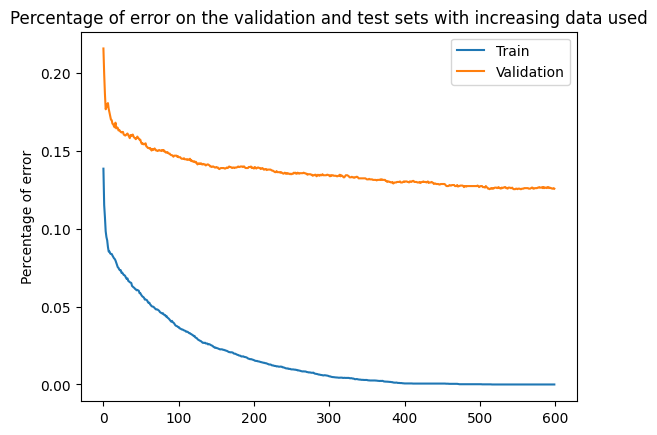

In [93]:
#We can see how fast the model "overfits" to the train dataset
plot_results(model)

We see that overfitting occurs very fast.

In [94]:
# we look at the most important features
features= pd.DataFrame(model.feature_importances_,index=X_train.columns)
print(features.sort_values(by=0,ascending=False))

                                           0
Climatic0                           0.266265
Climatic4                           0.191508
Soil_Type5                          0.069176
Soil_Type2                          0.066794
Wilderness_Area6                    0.058832
Soil_Type4                          0.052335
Soil_Type1                          0.049412
Elevation                           0.043469
Wilderness_Area1                    0.024883
Wilderness_Area0                    0.024525
Soil_Type0                          0.023535
Soil_Type6                          0.022515
Horizontal_Distance_To_Hydrology    0.009417
Geologic2                           0.009160
Horizontal_Distance_To_Roadways     0.008895
Soil_Type3                          0.008407
Horizontal_Distance_To_Fire_Points  0.008072
Hillshade_9am                       0.007655
Vertical_Distance_To_Hydrology      0.006600
Hillshade_Noon                      0.006242
Aspect                              0.006070
Geologic0 

In [95]:
mutual_info=pd.Series(mutual_info_classif(X_train,Y_train),index=X_train.columns).sort_values(ascending=False)
print(mutual_info)

Elevation                             1.017117
Soil_Type1                            0.912206
Soil_Type0                            0.863765
Soil_Type5                            0.754212
Soil_Type6                            0.743899
Soil_Type2                            0.720561
Climatic1                             0.711886
Climatic0                             0.704586
Climatic5                             0.702885
Climatic2                             0.697068
Climatic4                             0.696443
Soil_Type3                            0.693649
Soil_Type4                            0.672781
Climatic6                             0.663416
Climatic3                             0.539509
Wilderness_Area1                      0.520751
Wilderness_Area0                      0.517665
Wilderness_Area6                      0.512854
Wilderness_Area5                      0.499561
Wilderness_Area2                      0.498979
Wilderness_Area3                      0.410665
Wilderness_Ar

We aimed to identify the most important features in the model and compare this ranking with mutual information. It turns out that the ranking is loosely respected. However, it is clearly not exactly the same; for instance, Climatic0 emerges as an important feature for the model, whereas it is relatively less important according to mutual information. This difference can be explained by considering the links between the features themselves. Indeed, Climatic0 may be crucial because no other feature contains the same information about the coverage type, while the information from other features is redundant.

# Predicting 

In [96]:
X=preprocess(X, Y,True)
model=XGBClassifier(n_estimators=600,learning_rate=0.02,objective='multi:softmax',max_depth=12,subsample=0.7) #,num_class=7,eval_metric=["merror"],early_stopping_rounds=100
model.fit(X, Y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.02, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=12, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=600, n_jobs=None,
              num_parallel_tree=None, objective='multi:softmax', ...)

In [97]:
test_full=pd.read_csv("../data/test-full.csv")
test_full=test_full.set_index("Id")
test_full=preprocess(test_full,None,False)

All we need to do is predict and rename the results (they range from 1 to 7 instead of 0 to 6 as needed in our model).

In [98]:
pred=pd.DataFrame(model.predict(test_full)+1,columns=["Cover_Type"])
pred.index.name="Id"
pred.index+=1

In [99]:
pred.Cover_Type.value_counts()

2    234339
1    214771
3     37427
5     32287
7     31887
6     26100
4      4201
Name: Cover_Type, dtype: int64

It's interesting to note that the Cover_Types are not evenly distributed among all 7 categories.

The values above represent the number of times we predicted each category. While not the exact count of trees for each category, it provides a good representation, considering the predictions are accurate around $80%$ of the time.

In [100]:
pred.to_csv("../submission/res.csv")